## A quick and simple example of random forest in spark

Yet another notebook on the classic Kaggle titanic data set!

https://www.kaggle.com/c/titanic

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

### Create a spark session

`SparkSession` is a wrapper for spark context and sql context, making it convenient

In [2]:
spark = SparkSession.builder.appName("titanic").getOrCreate()

### Load data
The data includes header. Let pyspark figure out data types

In [3]:
datapath = 'data/titanic/train.csv'
raw = spark.read.csv(datapath, header=True, inferSchema=True)
raw.head(2)

[Row(PassengerId=1, Survived=0, Pclass=3, Name='Braund, Mr. Owen Harris', Sex='male', Age=22.0, SibSp=1, Parch=0, Ticket='A/5 21171', Fare=7.25, Cabin=None, Embarked='S'),
 Row(PassengerId=2, Survived=1, Pclass=1, Name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex='female', Age=38.0, SibSp=1, Parch=0, Ticket='PC 17599', Fare=71.2833, Cabin='C85', Embarked='C')]

From a quick look, looks like passengerID and Name are just identifiers for the
passengers and do not give useful information. Drop them.

In [4]:
raw = raw.drop("PassengerId").drop("Name")

Create a table for sql queries

In [5]:
raw.createOrReplaceTempView("stats")

### See number of missing values

`count` tells you the number of non-empty values. Use it to see how dirty the data are

In [6]:
raw.describe().filter(col("summary")=="count").show()

+-------+--------+------+---+---+-----+-----+------+----+-----+--------+
|summary|Survived|Pclass|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-------+--------+------+---+---+-----+-----+------+----+-----+--------+
|  count|     891|   891|891|714|  891|  891|   891| 891|  204|     889|
+-------+--------+------+---+---+-----+-----+------+----+-----+--------+



As a quick guess for numeric vs categorical. Super unreliable. You should read data description.

In [7]:
raw.dtypes

[('Survived', 'int'),
 ('Pclass', 'int'),
 ('Sex', 'string'),
 ('Age', 'double'),
 ('SibSp', 'int'),
 ('Parch', 'int'),
 ('Ticket', 'string'),
 ('Fare', 'double'),
 ('Cabin', 'string'),
 ('Embarked', 'string')]

### Get mean of numerical columns
Use built in summary method

In [8]:
raw.describe().select(["Pclass", "Age", "SibSp", "Parch", "Fare"]).filter(col("summary")=="mean").show()

+-----------------+-----------------+------------------+-------------------+----------------+
|           Pclass|              Age|             SibSp|              Parch|            Fare|
+-----------------+-----------------+------------------+-------------------+----------------+
|2.308641975308642|29.69911764705882|0.5230078563411896|0.38159371492704824|32.2042079685746|
+-----------------+-----------------+------------------+-------------------+----------------+



### Get mode of categorical columns

In [9]:
def get_mode(col):
    spark.sql("""
    select
       sum(case when {} is not null then 1 else 0 end) cnt, {}
    from stats
    group by {}
    order by 1 desc
    limit 1
    """.format(col, col, col)).show()

In [10]:
get_mode("Sex")
get_mode("Ticket")
get_mode("Cabin")
get_mode("Embarked")

+---+----+
|cnt| Sex|
+---+----+
|577|male|
+---+----+

+---+------+
|cnt|Ticket|
+---+------+
|  7|  1601|
+---+------+

+---+-------+
|cnt|  Cabin|
+---+-------+
|  4|B96 B98|
+---+-------+

+---+--------+
|cnt|Embarked|
+---+--------+
|644|       S|
+---+--------+



In [11]:
## No need to keep columns that are almost all different categorical values
raw = raw.drop("Ticket").drop("Cabin")
raw.head(3)

[Row(Survived=0, Pclass=3, Sex='male', Age=22.0, SibSp=1, Parch=0, Fare=7.25, Embarked='S'),
 Row(Survived=1, Pclass=1, Sex='female', Age=38.0, SibSp=1, Parch=0, Fare=71.2833, Embarked='C'),
 Row(Survived=1, Pclass=3, Sex='female', Age=26.0, SibSp=0, Parch=0, Fare=7.925, Embarked='S')]

In [12]:
# Fillnas using median of numerical values and mode for categorical, obtained above
raw = raw.fillna({"Age": 30, "Embarked": "S"})

In [13]:
# Check NA again. This time there should be no NA
raw.describe().filter(col("summary")=="count").show()

+-------+--------+------+---+---+-----+-----+----+--------+
|summary|Survived|Pclass|Sex|Age|SibSp|Parch|Fare|Embarked|
+-------+--------+------+---+---+-----+-----+----+--------+
|  count|     891|   891|891|891|  891|  891| 891|     891|
+-------+--------+------+---+---+-----+-----+----+--------+



### Now, take a small sample and plot with seaborn

In [14]:
subset, _ = raw.randomSplit([0.9, 0.1])

In [15]:
df = subset.toPandas()

In [16]:
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1,female,2.0,1,2,151.5500,S
1,0,1,female,25.0,1,2,151.5500,S
2,0,1,female,50.0,0,0,28.7125,C


Plot various ways to segment passengers and see if survival rates are different

In [17]:
import seaborn as sns
sns.set(style="whitegrid")

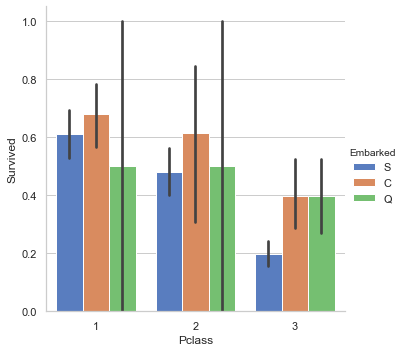

In [18]:
# Embarked
sns.catplot(data=df, x="Pclass", y="Survived", hue="Embarked", kind="bar", palette="muted")

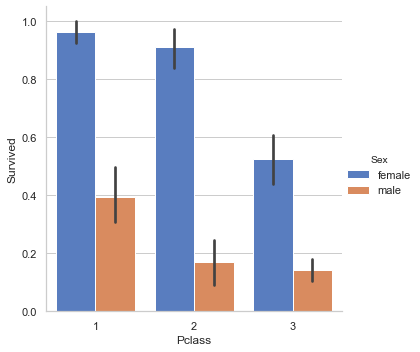

In [19]:
# Gender
sns.catplot(data=df, x="Pclass", y="Survived", hue="Sex", kind="bar", palette="muted")

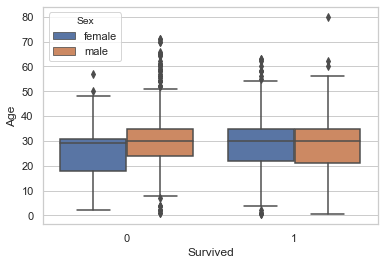

In [20]:
# How about age?
sns.boxplot(data=df, x="Survived", y="Age", hue="Sex")

Use Spark's machine learning library to process features and train a model

In [21]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler

In [22]:
cat_cols = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']

For all categorical columns, turn into indices and do one hot encoding

In [23]:
for col_name in cat_cols:
    print("Processing", col_name)
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + 'Index')
    indexed = indexer.fit(raw)
    raw = indexed.transform(raw)
    encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol()],
                                    outputCols=[col_name+'classVec'])
    raw = encoder.fit(raw).transform(raw)

Processing Pclass
Processing Sex
Processing Embarked
Processing SibSp
Processing Parch


In [24]:
raw.head(3)

[Row(Survived=0, Pclass=3, Sex='male', Age=22.0, SibSp=1, Parch=0, Fare=7.25, Embarked='S', PclassIndex=0.0, PclassclassVec=SparseVector(2, {0: 1.0}), SexIndex=0.0, SexclassVec=SparseVector(1, {0: 1.0}), EmbarkedIndex=0.0, EmbarkedclassVec=SparseVector(2, {0: 1.0}), SibSpIndex=1.0, SibSpclassVec=SparseVector(6, {1: 1.0}), ParchIndex=0.0, ParchclassVec=SparseVector(6, {0: 1.0})),
 Row(Survived=1, Pclass=1, Sex='female', Age=38.0, SibSp=1, Parch=0, Fare=71.2833, Embarked='C', PclassIndex=1.0, PclassclassVec=SparseVector(2, {1: 1.0}), SexIndex=1.0, SexclassVec=SparseVector(1, {}), EmbarkedIndex=1.0, EmbarkedclassVec=SparseVector(2, {1: 1.0}), SibSpIndex=1.0, SibSpclassVec=SparseVector(6, {1: 1.0}), ParchIndex=0.0, ParchclassVec=SparseVector(6, {0: 1.0})),
 Row(Survived=1, Pclass=3, Sex='female', Age=26.0, SibSp=0, Parch=0, Fare=7.925, Embarked='S', PclassIndex=0.0, PclassclassVec=SparseVector(2, {0: 1.0}), SexIndex=1.0, SexclassVec=SparseVector(1, {}), EmbarkedIndex=0.0, EmbarkedclassVec=

Put together numerical and processed categorical features

In [25]:
numericCols = ['Age', 'Fare']

In [26]:
feature_cols = [c + "classVec" for c in cat_cols] + numericCols
feature_cols

['PclassclassVec',
 'SexclassVec',
 'EmbarkedclassVec',
 'SibSpclassVec',
 'ParchclassVec',
 'Age',
 'Fare']

Use `VectorAssembler` to assemble features into arrays

In [27]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [28]:
processed = assembler.transform(raw)

In [29]:
processed.head()

Row(Survived=0, Pclass=3, Sex='male', Age=22.0, SibSp=1, Parch=0, Fare=7.25, Embarked='S', PclassIndex=0.0, PclassclassVec=SparseVector(2, {0: 1.0}), SexIndex=0.0, SexclassVec=SparseVector(1, {0: 1.0}), EmbarkedIndex=0.0, EmbarkedclassVec=SparseVector(2, {0: 1.0}), SibSpIndex=1.0, SibSpclassVec=SparseVector(6, {1: 1.0}), ParchIndex=0.0, ParchclassVec=SparseVector(6, {0: 1.0}), features=SparseVector(19, {0: 1.0, 2: 1.0, 3: 1.0, 6: 1.0, 11: 1.0, 17: 22.0, 18: 7.25}))

Fit a random forest model

In [30]:
clf = RandomForestClassifier(featuresCol="features", labelCol='Survived', numTrees=200,
                             maxDepth=4)

Split into train and test data. For simplicity, there's no cross validation partition

In [31]:
train, test = processed.randomSplit([0.7, 0.3])

Fit, predict, and measure

In [32]:
clf_fit = clf.fit(train)

In [33]:
pred = clf_fit.transform(test.select("features"))
pred.head()

Row(features=SparseVector(19, {1: 1.0, 3: 1.0, 6: 1.0, 13: 1.0, 17: 25.0, 18: 151.55}), rawPrediction=DenseVector([30.6165, 169.3835]), probability=DenseVector([0.1531, 0.8469]), prediction=1.0)

In [34]:
pred = pred.toPandas()['prediction']

In [35]:
y_true = test.toPandas()['Survived']

In [36]:
from sklearn.metrics import f1_score, accuracy_score

In [37]:
f1_score(y_pred=pred, y_true=y_true)

0.7446808510638298

In [38]:
accuracy_score(y_pred=pred, y_true=y_true)

0.8303886925795053